Dataset: We'll use the German Credit dataset which can be found here: https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

One approach to incorporating this information is to compute aggregate statistics for each individual's loan repayment history and transactional activities. For example, we could compute:

- Total amount of credit taken out by the individual
- Total amount of credit repaid by the individual
- Number of loans taken out by the individual
- Average loan duration for the individual
- Average credit amount for the individual
- Average installment rate for the individual
- Total number of missed payments by the individual
- Ratio of missed payments to total payments for the individual
- Total amount of transactions made by the individual
- Average transaction amount for the individual
- Total number of transactions in the past month for the individual
- Ratio of transaction amount to total credit taken out for the individual

Also to make the model more relevant to predicting loan defaults, we can add features that are related to loan repayment behavior and transactional activities, such as:
- Average monthly income
- Employment status (employed, unemployed, self-employed)
- Monthly debt payments
- Credit utilization ratio
- Number of late payments in the past
- Length of credit history
- Purpose of the loan
- Total debt to income ratio


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
columns = ['checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account',
           'employment_duration', 'installment_rate', 'personal_status', 'other_debtors', 'residence_duration',
           'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable',
           'telephone', 'foreign_worker', 'credit_risk']
credit_df = pd.read_csv(url, sep=' ', header=None, names=columns)
credit_df['debt_to_income_ratio'] = credit_df['credit_amount'] / credit_df['duration']
credit_df['monthly_debt_payments'] = credit_df['credit_amount'] / credit_df['installment_rate']
credit_df['credit_utilization_ratio'] = credit_df['credit_amount'] / credit_df['residence_duration']
credit_df['number_late_payments'] = credit_df['number_credits'] - credit_df['people_liable']
credit_df['credit_history_duration'] = credit_df['duration'] - credit_df['residence_duration']

# Compute aggregate statistics for each individual
grouped = credit_df.groupby(['checking_account', 'credit_history']).agg({
    'duration': ['mean', 'std'],
    'credit_amount': ['sum', 'mean'],
    'installment_rate': ['mean'],
    'credit_risk': ['mean'],
})
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()

# Merge the aggregate statistics with the original dataset
credit_df = credit_df.merge(grouped, on=['checking_account', 'credit_history'], how='left')

# Split the data into training and testing sets
X = credit_df.drop('credit_risk', axis=1)
y = credit_df['credit_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
categorical_cols = ['checking_account', 'credit_history', 'purpose', 'savings_account', 'employment_duration',
                    'personal_status', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job',
                    'telephone', 'foreign_worker']
numeric_cols = ['duration', 'credit_amount', 'installment_rate', 'residence_duration', 'age', 'number_credits',
                'people_liable', 'debt_to_income_ratio', 'monthly_debt_payments', 'credit_utilization_ratio',
                'number_late_payments', 'credit_history_duration']

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("RandomForestClassifier\n")
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_preprocessed, y_train)
y_pred = rfc.predict(X_test_preprocessed)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

print("\nGradientBoostingClassifier\n")
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_preprocessed, y_train)
y_pred = gbc.predict(X_test_preprocessed)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

RandomForestClassifier

Accuracy: 0.765
Precision: 0.7831325301204819
Recall: 0.9219858156028369
F1 Score: 0.8469055374592833

GradientBoostingClassifier

Accuracy: 0.795
Precision: 0.8012048192771084
Recall: 0.9432624113475178
F1 Score: 0.8664495114006514


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_10132\1964562274.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = credit_df.corr()


Text(0.5, 1.0, 'Histogram of Credit Amount by Credit Risk')

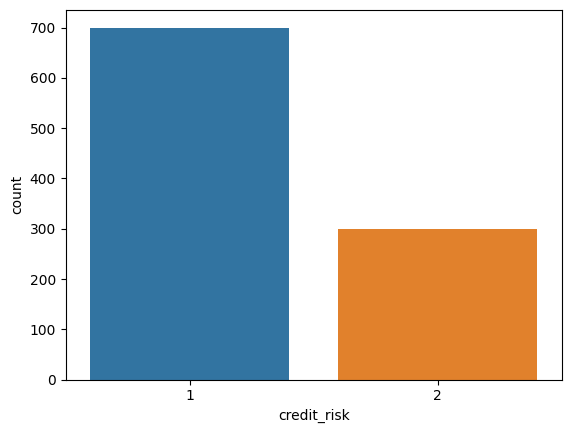

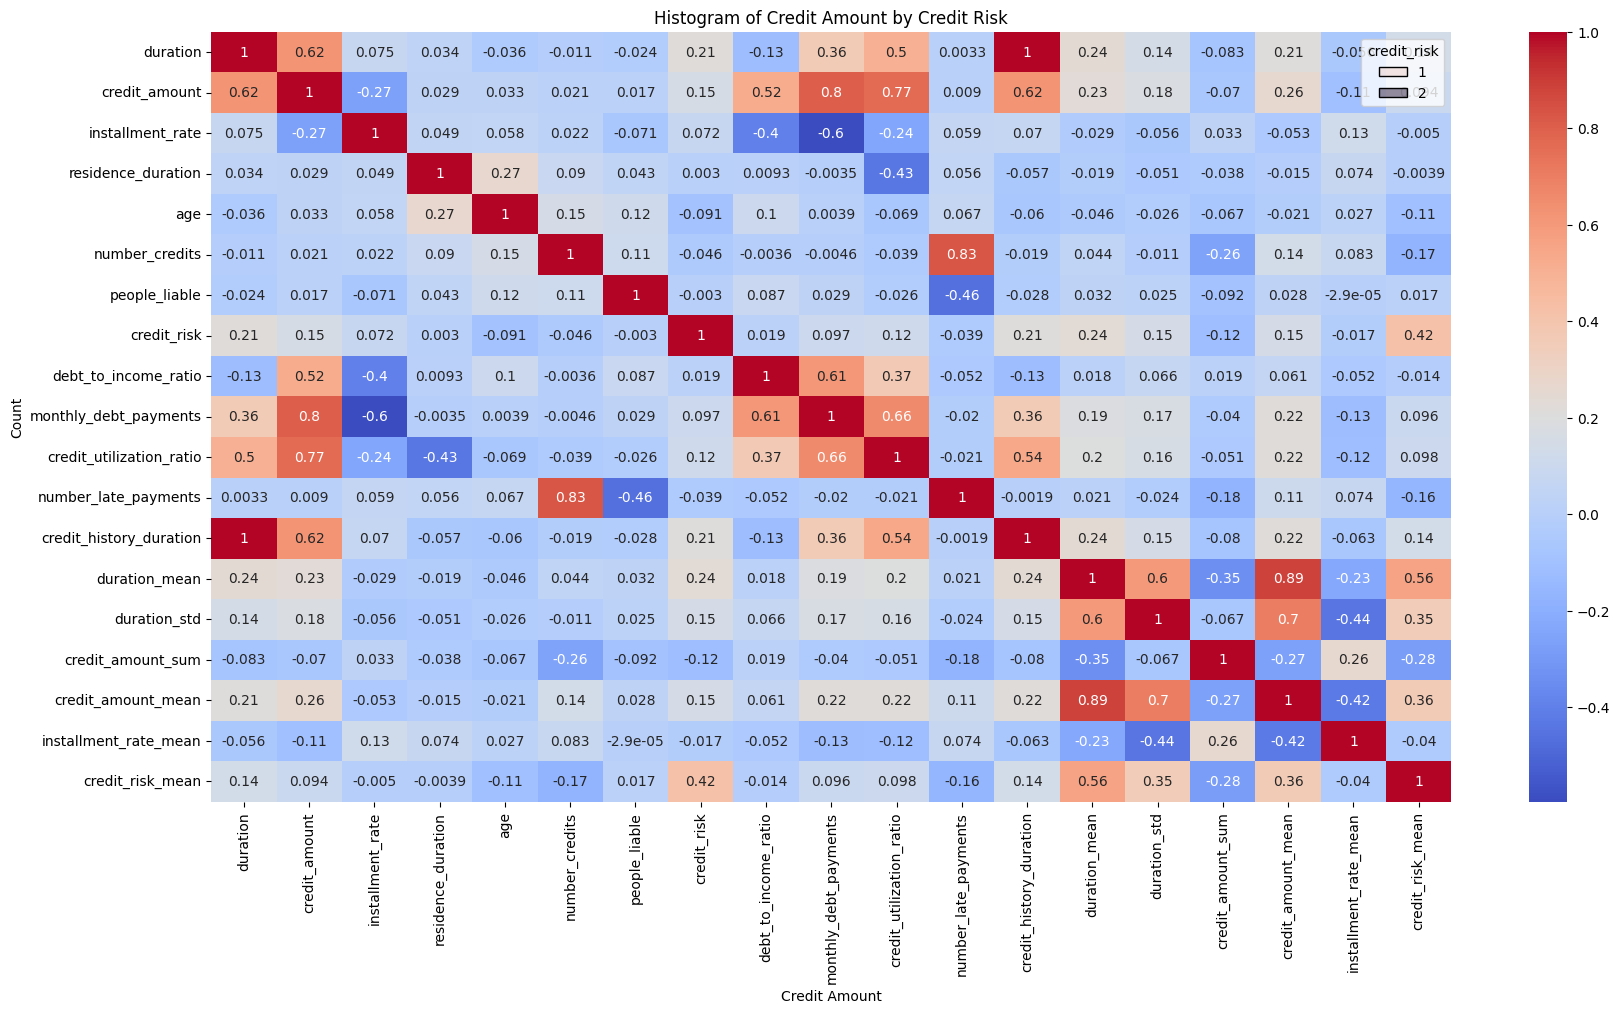

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of credit risk
sns.countplot(x='credit_risk', data=credit_df)
plt.figure(figsize=(20, 10))
plt.xlabel('Credit Risk')
plt.ylabel('Count')
plt.title('Distribution of Credit Risk')

# Plot correlation matrix
corr_matrix = credit_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

# Plot histogram of credit amount by credit risk
sns.histplot(x='credit_amount', hue='credit_risk', data=credit_df, kde=True)
plt.xlabel('Credit Amount')
plt.title('Histogram of Credit Amount by Credit Risk')


Text(0.5, 1.0, 'Scatterplot of Credit Amount vs. Duration Colored by Credit Risk')

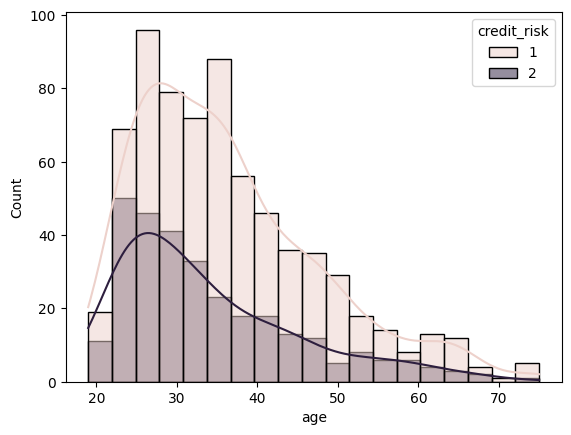

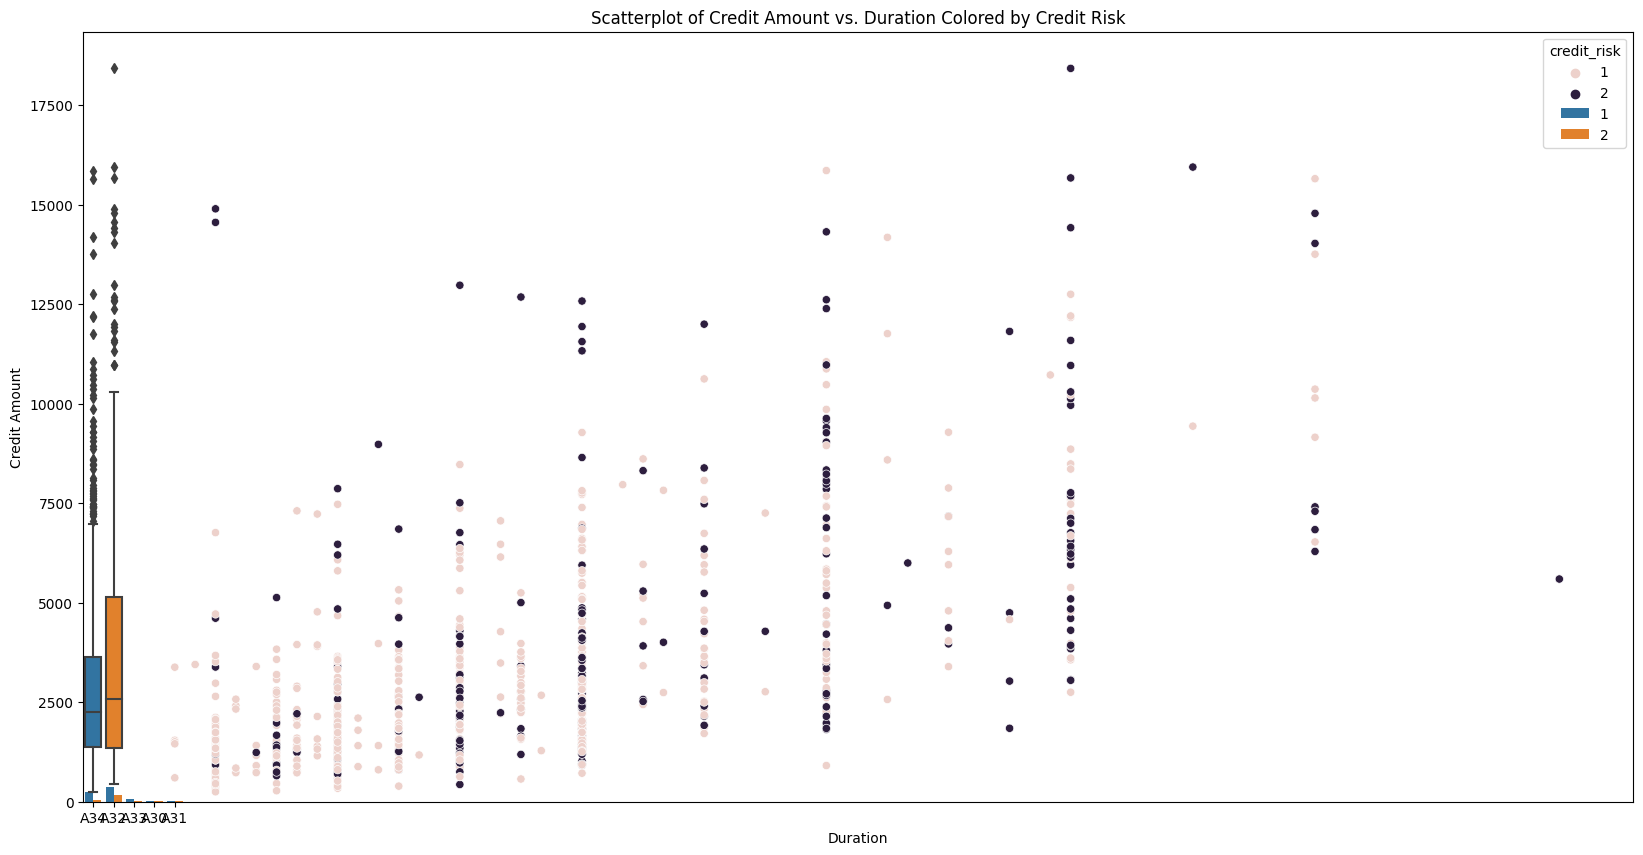

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of age by credit risk
sns.histplot(x='age', hue='credit_risk', data=credit_df, kde=True)
plt.figure(figsize=(20, 10))
plt.xlabel('Age')
plt.title('Histogram of Age by Credit Risk')

# Plot boxplot of credit amount by credit risk
sns.boxplot(x='credit_risk', y='credit_amount', data=credit_df)
plt.xlabel('Credit Risk')
plt.ylabel('Credit Amount')
plt.title('Boxplot of Credit Amount by Credit Risk')

# Plot countplot of credit history by credit risk
sns.countplot(x='credit_history', hue='credit_risk', data=credit_df)
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.title('Countplot of Credit History by Credit Risk')

# Plot scatterplot of credit amount vs. duration colored by credit risk
sns.scatterplot(x='duration', y='credit_amount', hue='credit_risk', data=credit_df)
plt.xlabel('Duration')
plt.ylabel('Credit Amount')
plt.title('Scatterplot of Credit Amount vs. Duration Colored by Credit Risk')


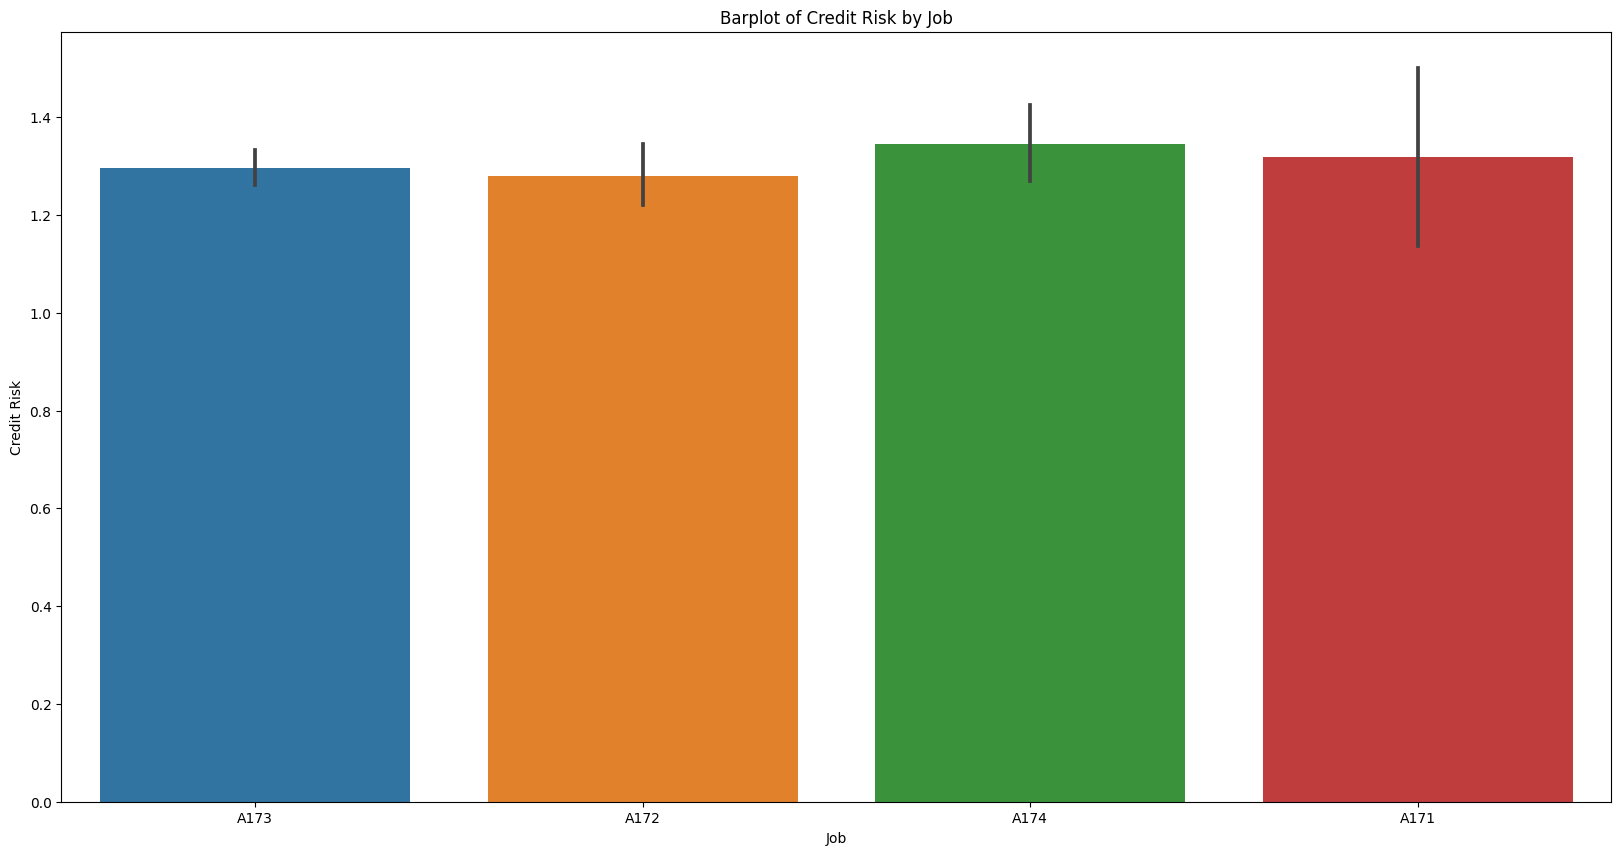

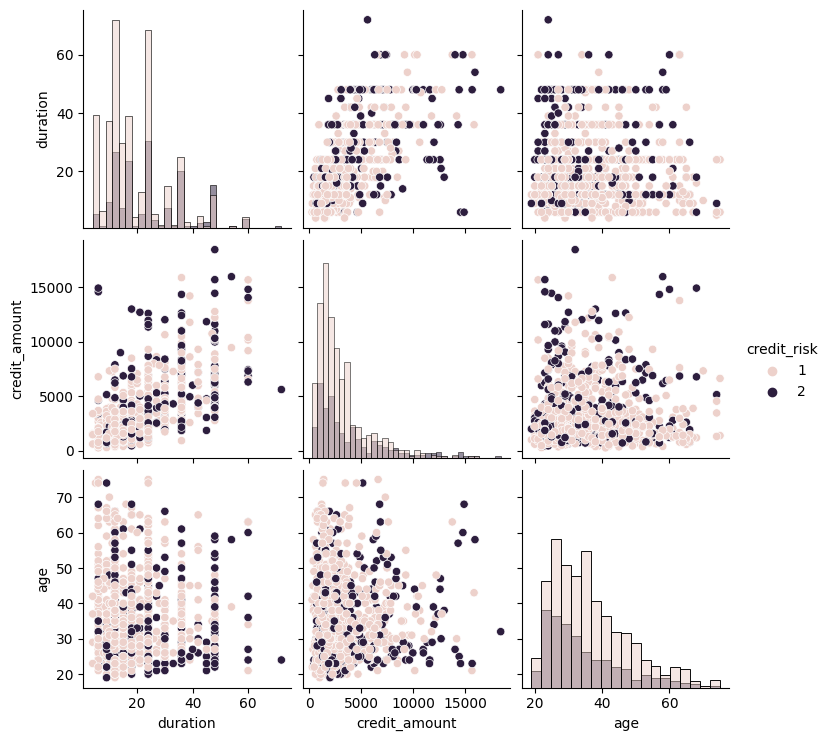

<Figure size 2000x1000 with 0 Axes>

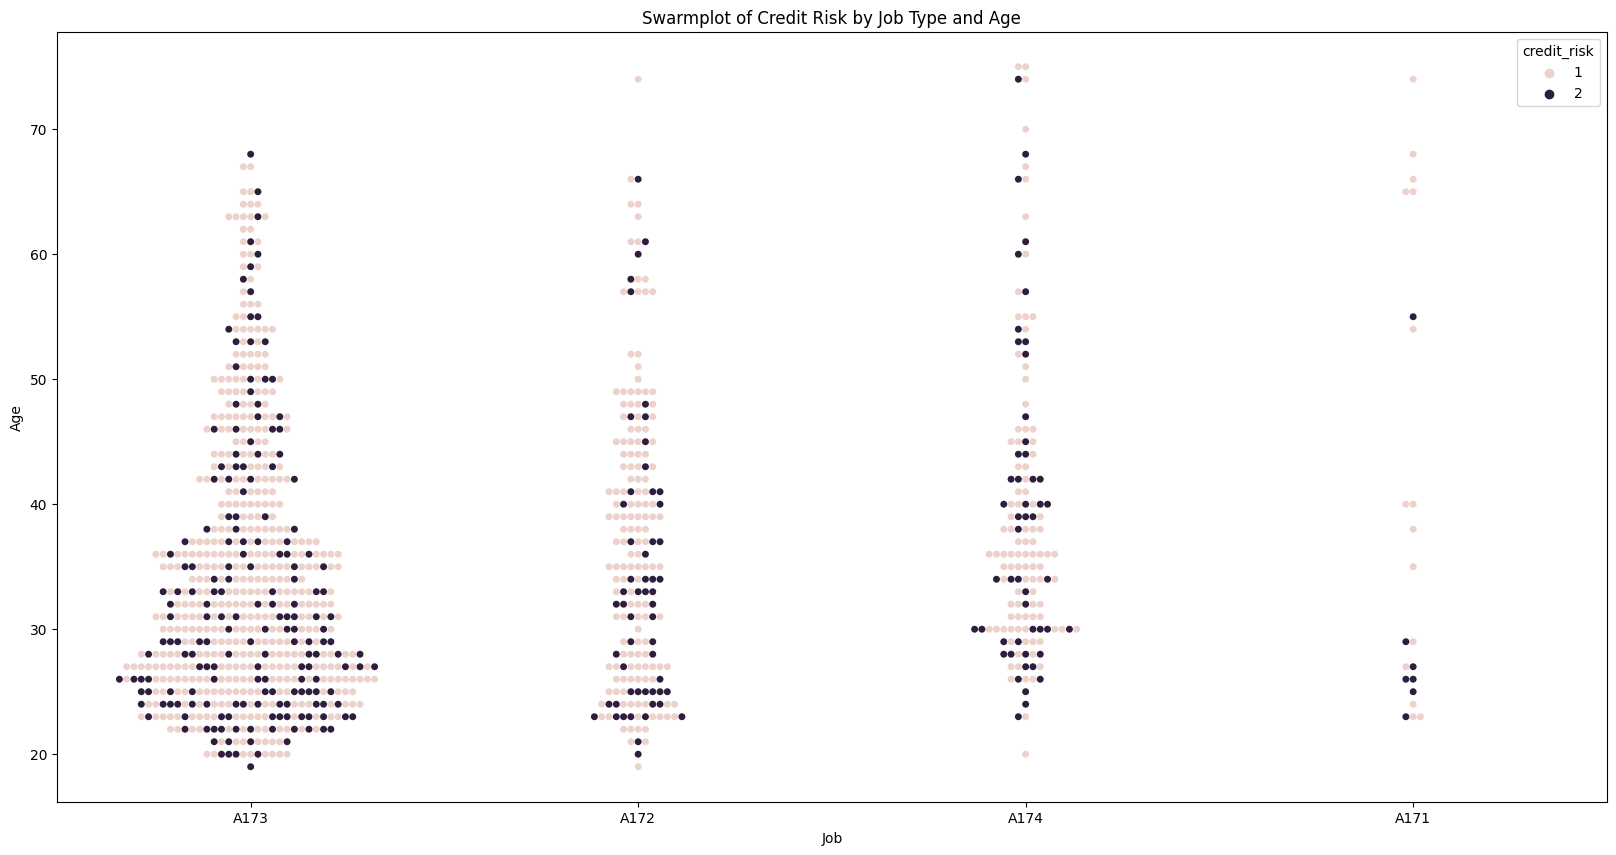

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase plot size
plt.figure(figsize=(20, 10))

# Plot barplot of credit risk by job
sns.barplot(x='job', y='credit_risk', data=credit_df)
plt.xlabel('Job')
plt.ylabel('Credit Risk')
plt.title('Barplot of Credit Risk by Job')

# Show plot
plt.show()

# Plot pairplot of numeric variables colored by credit risk
sns.pairplot(data=credit_df, vars=['duration', 'credit_amount', 'age'], hue='credit_risk', diag_kind='hist')
plt.figure(figsize=(20, 10))
plt.suptitle('Pairplot of Numeric Variables Colored by Credit Risk')

# Show plot


plt.show()

plt.figure(figsize=(20, 10))
# Plot swarmplot of credit risk by job type and age
sns.swarmplot(x='job', y='age', hue='credit_risk', data=credit_df)
plt.xlabel('Job')
plt.ylabel('Age')
plt.title('Swarmplot of Credit Risk by Job Type and Age')

# Show plot
plt.show()
